# Example - Zonal Statistics
This is useful in the case where you want to get regional statistics for a raster.

In [1]:
import geopandas as gpd
import numpy
import rioxarray
import xarray

from geocube.api.core import make_geocube

%matplotlib inline

## Download the source raster data

In [2]:
# !wget https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n42w091_IMG.zip

## Create the data mask by rasterizing the unique ID of the vector data

See docs for [make_geocube](../geocube.rst#make-geocube)

In [3]:
ssurgo_data = gpd.read_file("../../test/test_data/input/soil_data_group.geojson")
ssurgo_data = ssurgo_data.loc[ssurgo_data.hzdept_r==0]
# convert the key to group to the vector data to an integer as that is one of the
# best data types for this type of mapping. If your data is not integer,
# then consider using a mapping of your data to an integer with something
# like a categorical dtype.
ssurgo_data["mukey"] = ssurgo_data.mukey.astype(int)

In [4]:
# load in source elevation data subset relevant for the vector data
elevation = rioxarray.open_rasterio(
    "zip://USGS_NED_13_n42w091_IMG.zip/USGS_NED_13_n42w091_IMG.img", masked=True
).rio.clip(
    ssurgo_data.geometry.values, ssurgo_data.crs, from_disk=True
).sel(band=1).drop("band")
elevation.name = "elevation"

In [5]:
out_grid = make_geocube(
    vector_data=ssurgo_data,
    measurements=["mukey"],
    like=elevation, # ensure the data are on the same grid
)

In [6]:
# merge the two together
out_grid["elevation"] = (elevation.dims, elevation.values, elevation.attrs, elevation.encoding)
out_grid

<xarray.Dataset>
Dimensions:      (x: 178, y: 178)
Coordinates:
  * y            (y) float64 41.5 41.5 41.5 41.5 ... 41.48 41.48 41.48 41.48
  * x            (x) float64 -90.6 -90.6 -90.6 -90.6 ... -90.58 -90.58 -90.58
    spatial_ref  int64 0
Data variables:
    mukey        (y, x) float64 1.988e+05 1.988e+05 ... 1.987e+05 1.987e+05
    elevation    (y, x) float64 173.7 172.0 171.1 170.6 ... 181.0 181.2 181.4
Attributes:
    grid_mapping:  spatial_ref

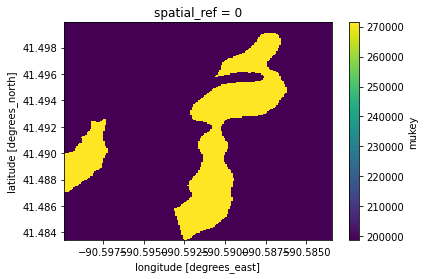

In [7]:
out_grid.mukey.plot.imshow()

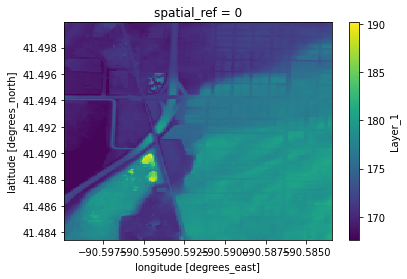

In [8]:
out_grid.elevation.plot()

### Get the elevation statistics of each region using the mask

In [9]:
grouped_elevation = out_grid.drop("spatial_ref").groupby(out_grid.mukey)
grid_mean = grouped_elevation.mean().rename({"elevation": "elevation_mean"})
grid_min = grouped_elevation.min().rename({"elevation": "elevation_min"})
grid_max = grouped_elevation.max().rename({"elevation": "elevation_max"})
grid_std = grouped_elevation.std().rename({"elevation": "elevation_std"})

In [10]:
zonal_stats = xarray.merge([grid_mean, grid_min, grid_max, grid_std]).to_dataframe()
zonal_stats

,elevation_mean,elevation_min,elevation_max,elevation_std
mukey,,,,
198692.0,173.130925,169.394562,188.442505,3.307044
198714.0,175.061542,170.214157,179.716675,2.148920
198724.0,179.933075,178.237244,181.490387,0.628017
198750.0,176.188453,167.951233,190.138763,3.814724
198754.0,171.632181,167.610321,181.611298,2.996241
271425.0,167.973730,167.951233,168.476776,0.076759
271431.0,176.718330,170.258133,180.460220,2.732228


In [11]:
ssurgo_data = ssurgo_data.merge(zonal_stats, on="mukey")

<AxesSubplot:>

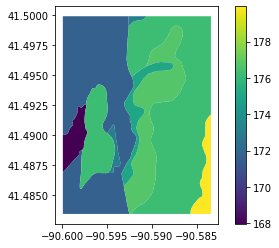

In [12]:
ssurgo_data.plot(column="elevation_mean", legend=True)

<AxesSubplot:>

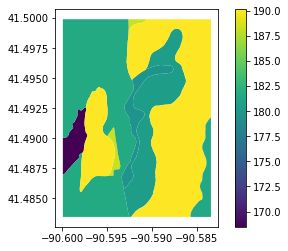

In [13]:
ssurgo_data.plot(column="elevation_max", legend=True)